In [1]:
#from https://nbviewer.jupyter.org/github/hackingmaterials/matminer_examples/tree/master

from matminer.data_retrieval import retrieve_MDF
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

quick_demo = True

In [2]:
#retrive dataset
mdf = retrieve_MDF.MDFDataRetrieval(anonymous=True)
query_string = 'mdf.source_name:oqmd AND (oqmd.configuration:static OR '\
    'oqmd.configuration:standard) AND dft.converged:True'
if quick_demo:
    query_string += " AND mdf.scroll_id:<20000"
data = mdf.get_data(query_string, unwind_arrays=False)

In [3]:
# show data features
print(data.columns)

Index(['crystal_structure.cross_reference.icsd',
       'crystal_structure.number_of_atoms',
       'crystal_structure.space_group_number', 'crystal_structure.volume',
       'dft.converged', 'dft.cutoff_energy',
       'dft.exchange_correlation_functional', 'files', 'material.composition',
       'material.elements', 'mdf.ingest_date', 'mdf.resource_type',
       'mdf.scroll_id', 'mdf.source_id', 'mdf.source_name', 'mdf.version',
       'oqmd.band_gap.units', 'oqmd.band_gap.value', 'oqmd.configuration',
       'oqmd.delta_e.units', 'oqmd.delta_e.value',
       'oqmd.magnetic_moment.units', 'oqmd.magnetic_moment.value',
       'oqmd.stability.units', 'oqmd.stability.value',
       'oqmd.total_energy.units', 'oqmd.total_energy.value',
       'oqmd.volume_pa.units', 'oqmd.volume_pa.value'],
      dtype='object')


In [4]:
# just get formation energy and material composition
data = data[['oqmd.delta_e.value', 'material.composition']]
# and rename
data = data.rename(columns={'oqmd.delta_e.value': 'delta_e', 'material.composition':'composition'})

In [5]:
# convert composition string to tuple of elements
data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'composition')

In [6]:
# remove samples without delta e
for k in ['delta_e']:
    data[k] = pd.to_numeric(data[k])
original_count = len(data)
data = data[~ data['delta_e'].isnull()]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 747/9718 entries


In [7]:
#get only lowest energy structures
original_count = len(data)
data['composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
data.sort_values('delta_e', ascending=True, inplace=True)
data.drop_duplicates('composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 104/8971 entries


In [8]:
# remove any outliers (based on energy)
original_count = len(data)
data = data[np.logical_and(data['delta_e'] >= -20, data['delta_e'] <= 5)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 2/8867 entries


In [9]:
#compute some respresentation of the structures based only on composition
#here we use the features from https://www.nature.com/articles/npjcompumats201628 (145 features)
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()
data = feature_calculators.featurize_dataframe(data, col_id='composition_obj')
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))


Generated 145 features
Training set size: 8865x145


In [10]:
# just remove any samples where there are empty features
original_count = len(data)
data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/8865 entries


In [11]:
# now lets train a model 
# we will train a random forest regressor and tune the paramters using a grid search
model = GridSearchCV(RandomForestRegressor(n_estimators=100, n_jobs=-1),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))
model.fit(data[feature_labels], data['delta_e'])

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_features': range(8, 15)},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'RMSE (eV/atom)')

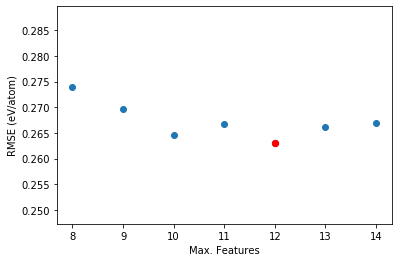

In [12]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

In [13]:
# save the best model
model = model.best_estimator_

In [14]:
# test the model using 10-fold cross validation
cv_prediction = cross_val_predict(model, data[feature_labels], data['delta_e'], cv=KFold(10, shuffle=True))

In [15]:
# compute the results from the cross-validation
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['delta_e'], cv_prediction)
    print(scorer, score)

r2_score 0.8692105845252671
mean_absolute_error 0.1580402555600012
mean_squared_error 0.06548770029382012


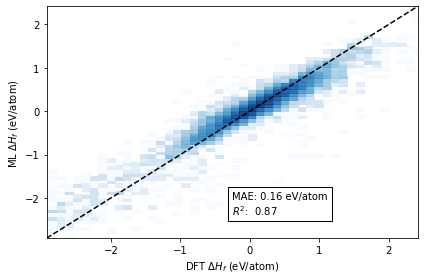

In [17]:
# plot result
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(data['delta_e']), cv_prediction, norm=LogNorm(), bins=64, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(data['delta_e'], cv_prediction)
r2 = metrics.r2_score(data['delta_e'], cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

#fig.set_size_inches(3, 3)
fig.tight_layout()
plt.show()